In [301]:
import os
import random

import cv2 as cv
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from PIL import Image as pil_image
from numpy import linalg as la

# Utilities

In [337]:
def imgs_show(imgs, rows, fontsize=36):
    fig = plt.figure()
    for n, (img, title) in enumerate(imgs):
        a = fig.add_subplot(rows, np.ceil(len(imgs)/float(rows)), n + 1)
        a.set_title(title, fontdict={"fontsize": fontsize})
        plt.imshow(img)
    fig.set_size_inches(np.array(fig.get_size_inches()) * len(imgs))
    plt.show()

def read_folder(folder, ext):
    images = []
    for filename in sorted(os.listdir(folder)):
        if filename.endswith(ext):
            path = os.path.join(folder, filename)
            images.append(np.array(pil_image.open(path)))
    return images

def img_show(img, title = '', figsize=(10, 5)):
    plt.figure(figsize=figsize)
    plt.gray()
    plt.imshow(img)
    plt.title(title)
    plt.show()
    
def read_frames_dataset(path, sep=',', ext='.jpg'):
    frames = read_folder(os.path.join(path, 'img/'), ext)
    df = pd.read_csv(os.path.join(path, 'groundtruth_rect.txt'), names=['x', 'y', 'w', 'h'], sep=sep)
    return frames, df

def cut_img(img, roi):
    (x, y, w, h) = roi
    roi = img[y:y + h, x:x + w]
    return np.copy(roi)

def sliding_window(image, stepSize, windowSize):
    """
        Function is taken from:
        https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/
    """
    # slide a window across the image
    for y in range(0, image.shape[0] - windowSize[0], stepSize):
        for x in range(0, image.shape[1] - windowSize[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def test(frames, df, method, n=3, step=3):
    roi = df.iloc[0]
    template = cut_img(frames[0], (roi["x"], roi["y"], roi["w"], roi["h"]))
    for i in range(0, n*step, 3):
        method.test(frames[i], template)

# Load and configure data

[Datasets source](http://cvlab.hanyang.ac.kr/tracker_benchmark/datasets.html)

In [222]:
names = {
    "transformer": './datasets/Transformer/',
    "bike": './datasets/MountainBike/', 
    "girl": './datasets/Girl/', 
    "bolt": './datasets/Bolt/', 
    "car": './datasets/CarScale/'
}

In [223]:
bike, bike_df = read_frames_dataset(names["bike"])
girl, girl_df = read_frames_dataset(names["girl"], sep='\t')
bolt, bolt_df = read_frames_dataset(names["bolt"])

# example
bike_df.head()

x    y   w   h
0  319  185  67  56
1  316  183  67  56
2  315  182  66  56
3  313  181  66  56
4  311  181  66  55

# Template matching

## SSD method

In [324]:
class SSD:
    @staticmethod
    def run(img, template):
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
        
        imgH, imgW = img.shape
        winH, winW = template.shape
        
        score = np.Inf
        coords = (0, 0)
        
        for (x, y, window) in sliding_window(img, stepSize=1, windowSize=(winW, winH)):
            # if the window does not meet our desired window size, ignore it
            if window.shape[0] != winH or window.shape[1] != winW:
                continue
            
            tmp = la.norm(window - template)
            if score > tmp:
                score = tmp
                coords = (x, y)
        
        return coords
        
    @staticmethod
    def test(source, template):
        (x, y) = SSD.run(source, template)
        result = cut_img(source, (x, y, template.shape[1], template.shape[0]))
        imgs_show([(source, "source"), (template, "template"), (result, "result")], 1)

## SSD Test

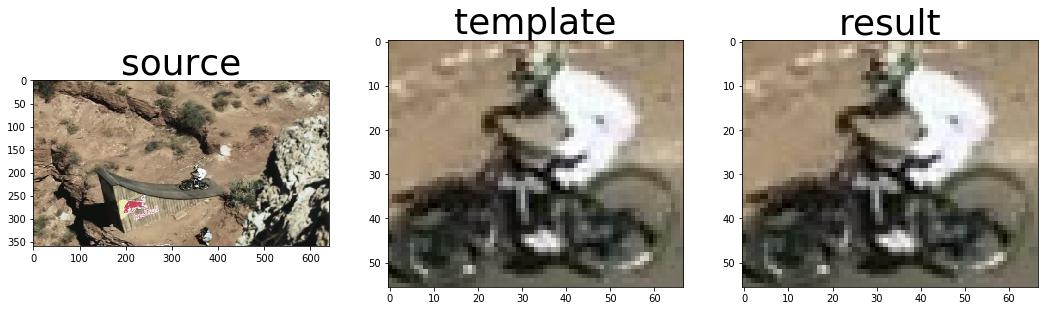

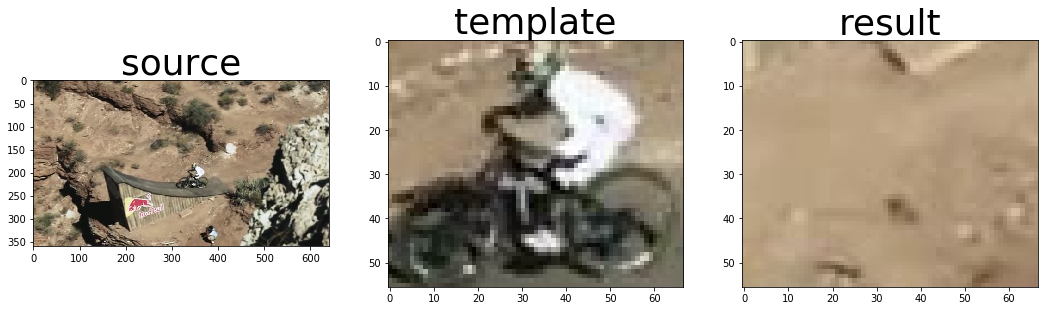

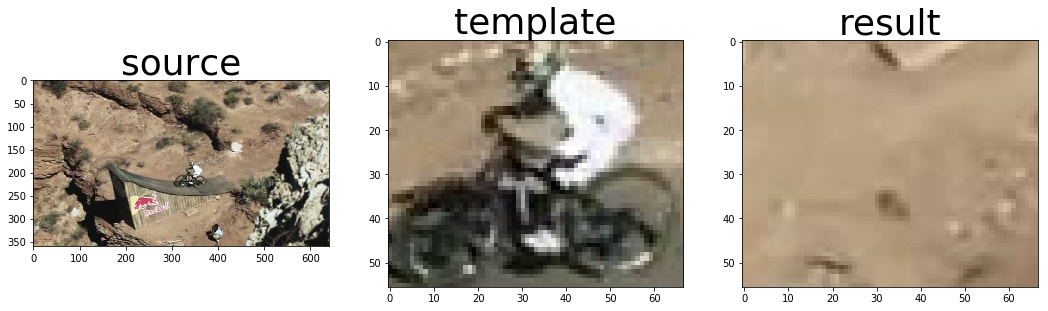

In [338]:
test(bike, bike_df, SSD) # step is 3 frames

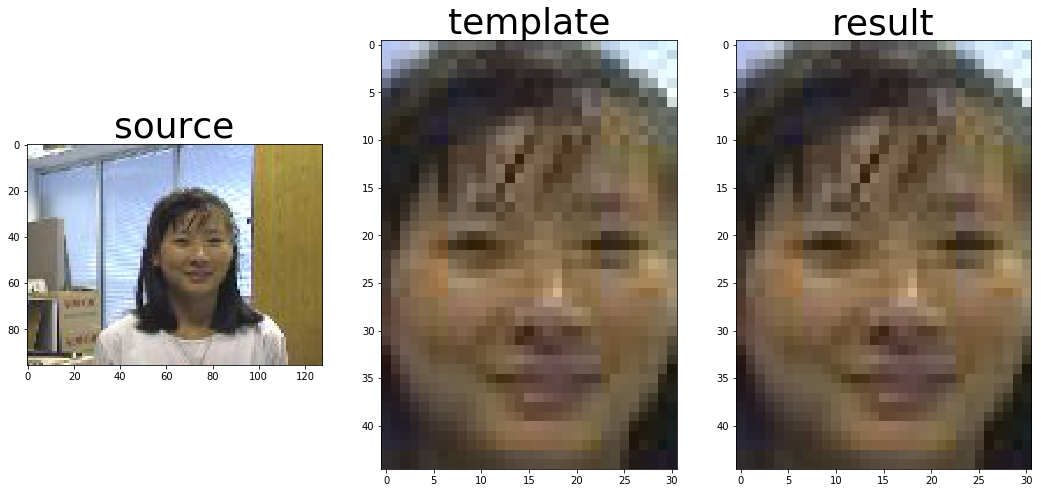

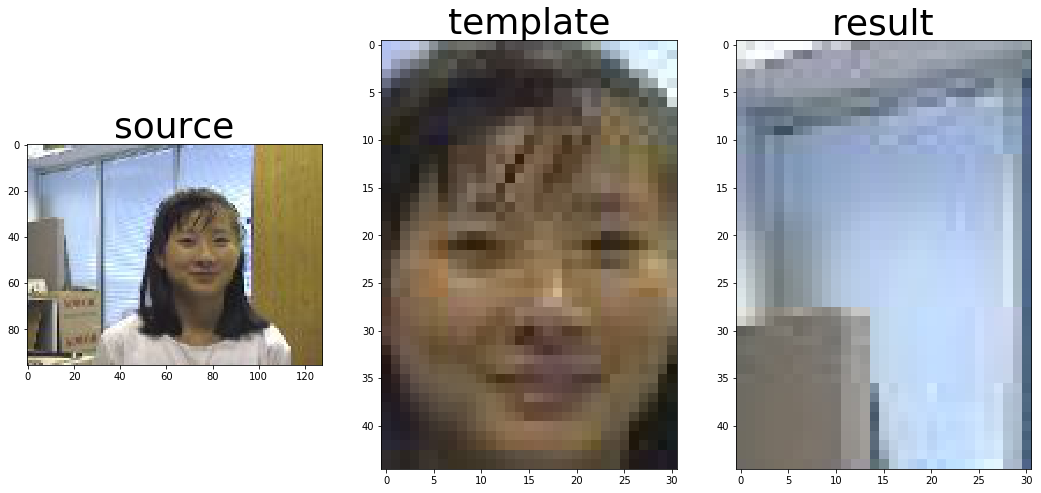

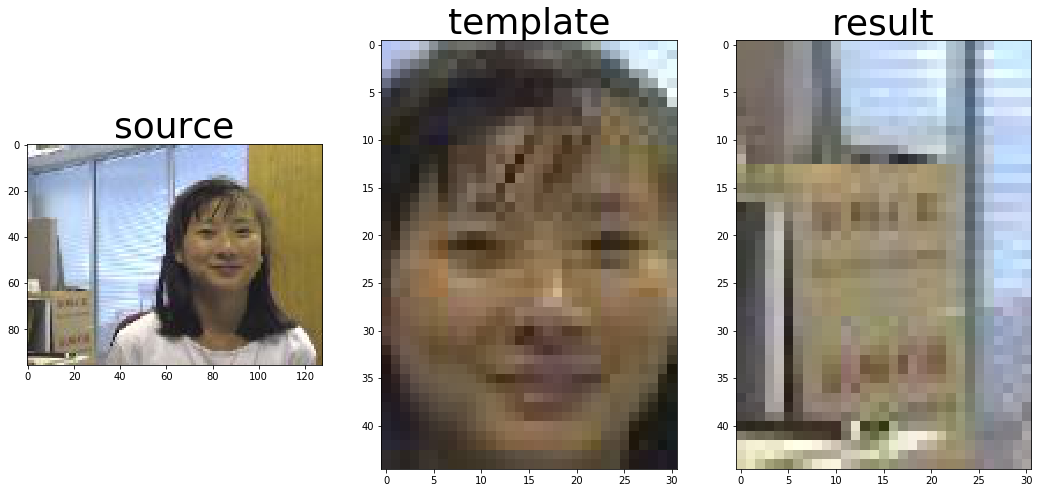

In [339]:
test(girl, girl_df, SSD) # step is 3 frames

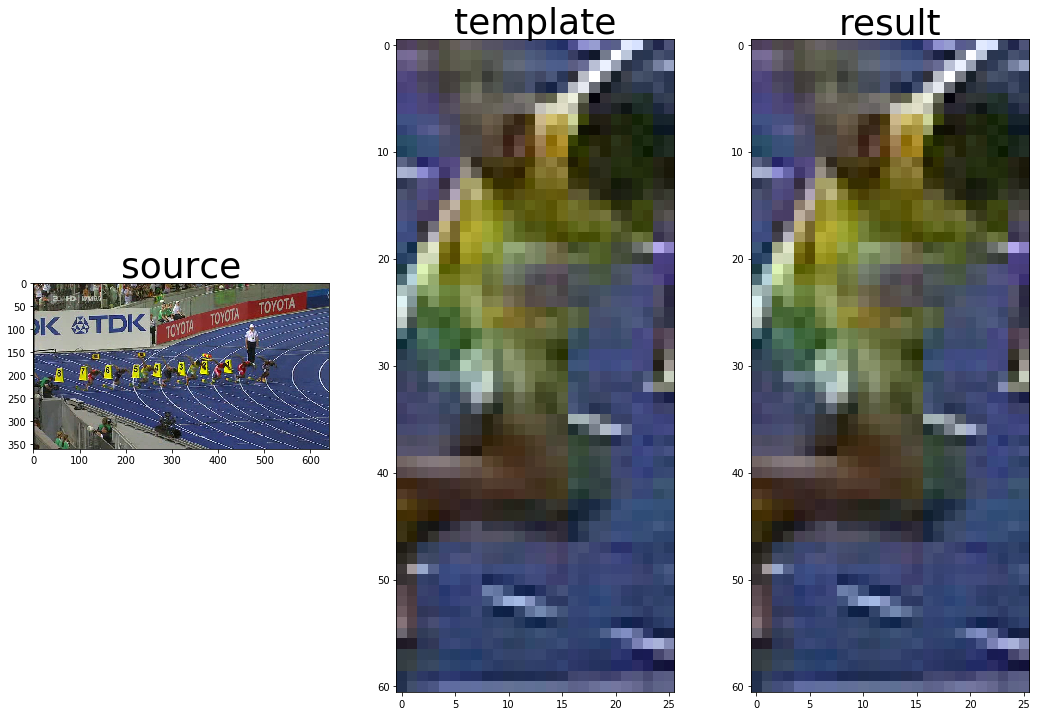

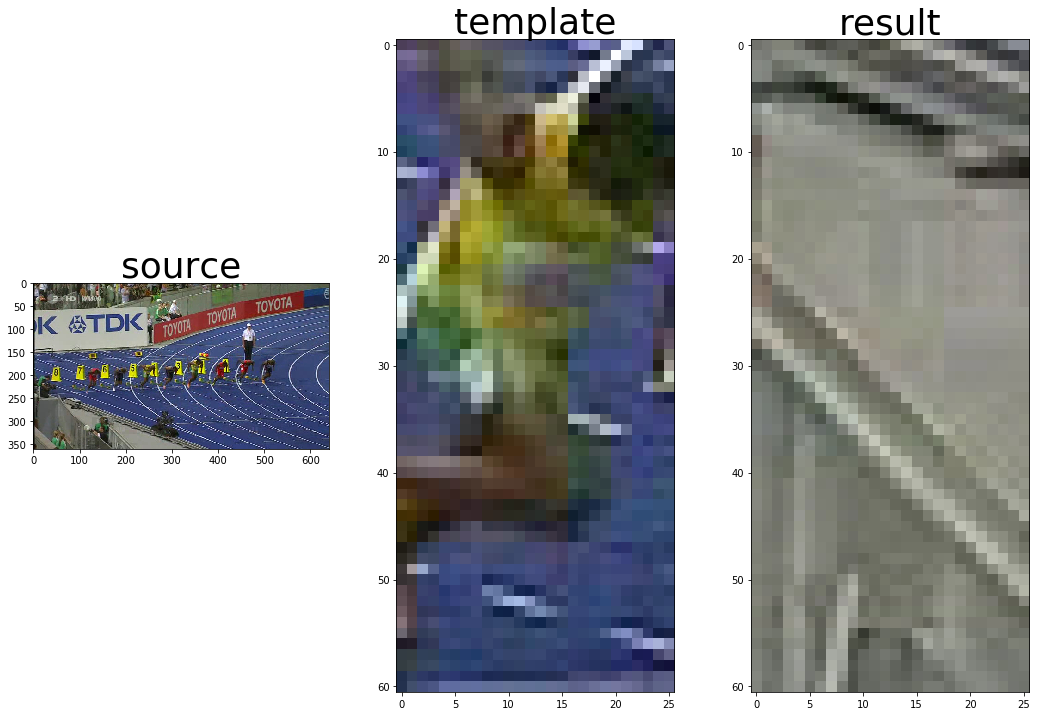

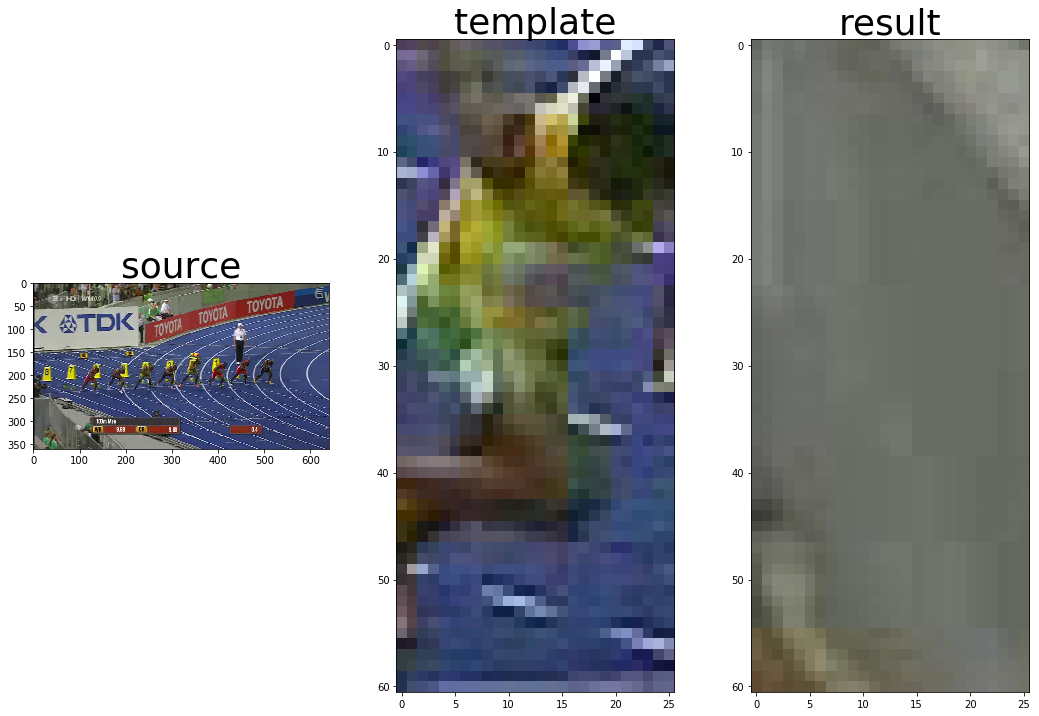

In [340]:
test(bolt, bolt_df, SSD) # step is 3 frames

# NCC method

In [347]:
class NCC:
    @staticmethod
    def run(img, template):
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
        
        imgH, imgW = img.shape
        winH, winW = template.shape
        
        corr = 0
        coords = (0, 0)
        
        normalized_template = template / np.sqrt(np.sum(template ** 2))
        
        for (x, y, window) in sliding_window(img, stepSize=1, windowSize=(winW, winH)):
            # if the window does not meet our desired window size, ignore it
            if window.shape[0] != winH or window.shape[1] != winW:
                continue
                
            normalized_window = window / np.sqrt(np.sum(window ** 2))
            
            tmp = np.corrcoef(normalized_window, normalized_template)
            
            if corr < tmp:
                corr = tmp
                coords = (x, y)
        
        return coords
        
    @staticmethod
    def test(source, template):
        (x, y) = SSD.run(source, template)
        result = cut_img(source, (x, y, template.shape[1], template.shape[0]))
        imgs_show([(source, "source"), (template, "template"), (result, "result")], 1)

## NCC Test

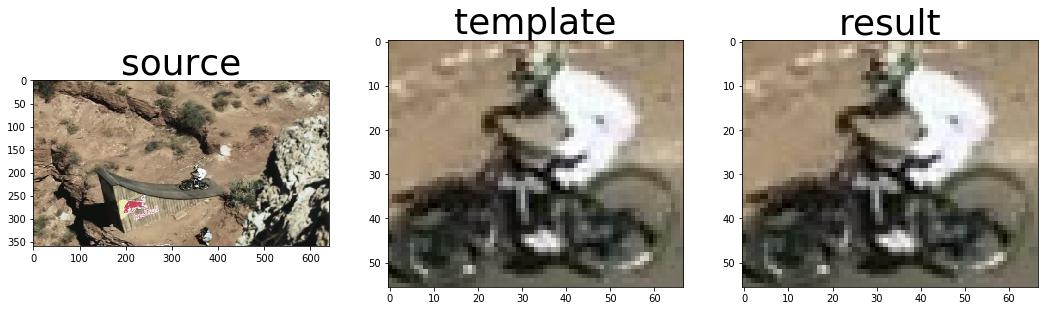

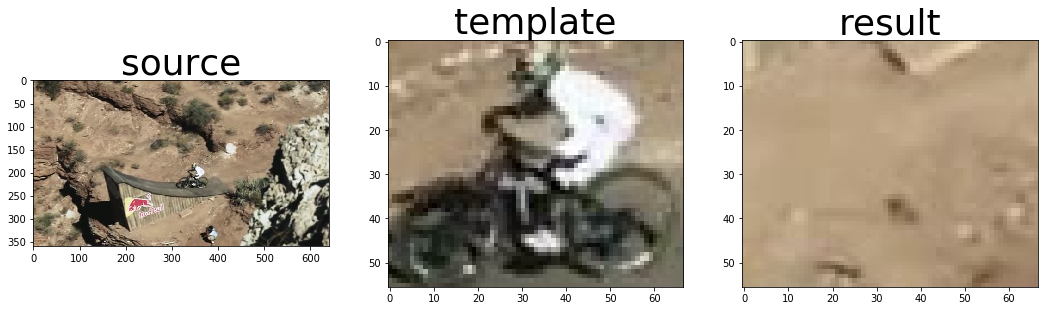

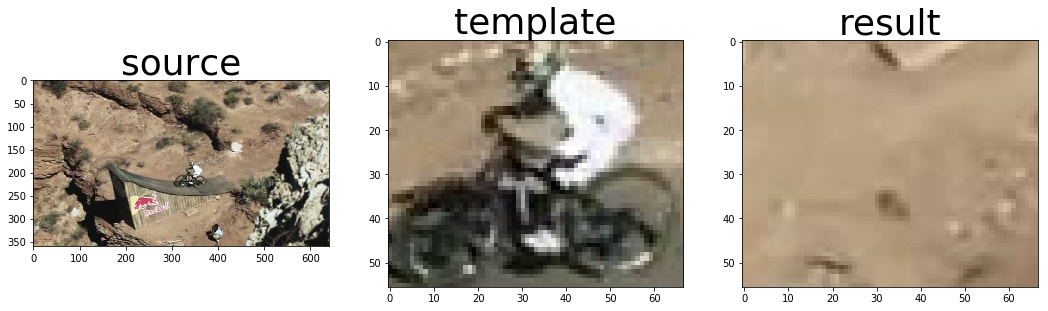

In [348]:
test(bike, bike_df, NCC) # step is 3 frames

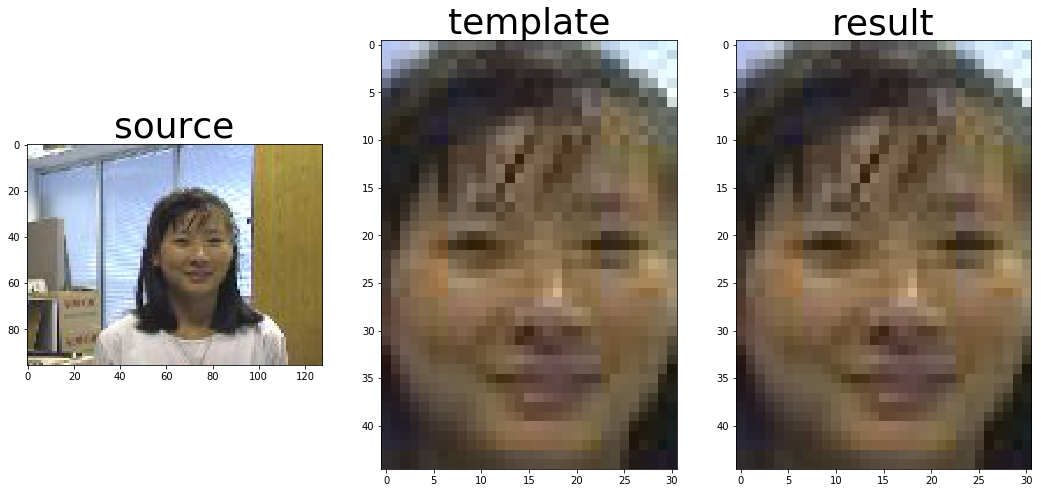

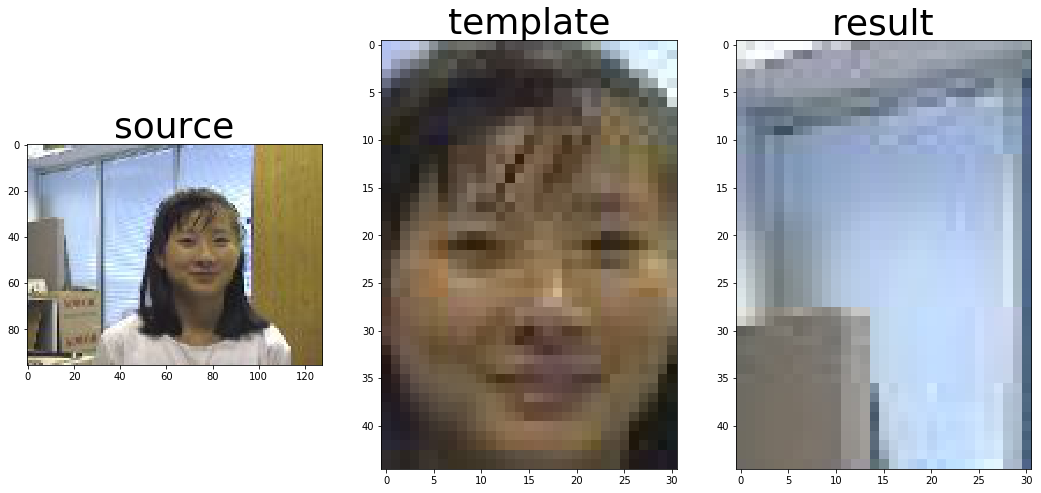

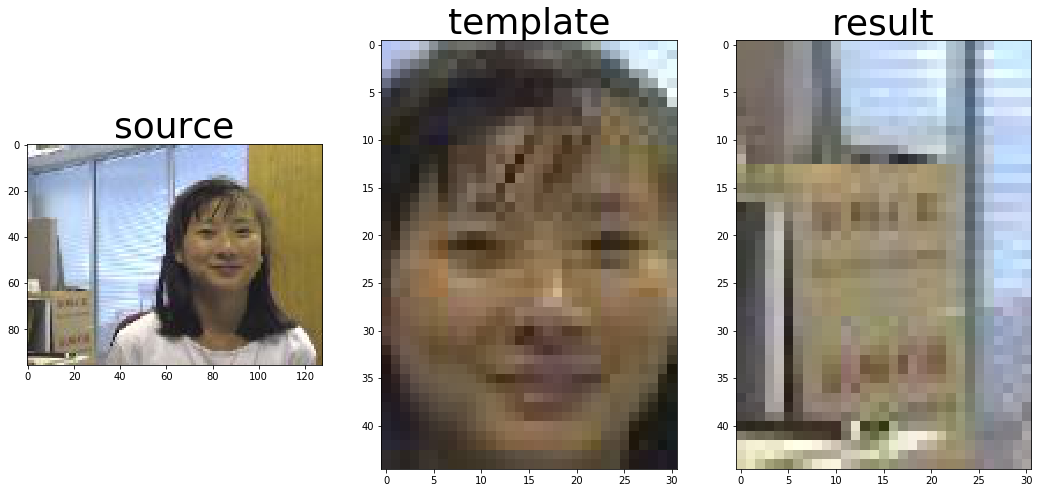

In [349]:
test(girl, girl_df, NCC) # step is 3 frames

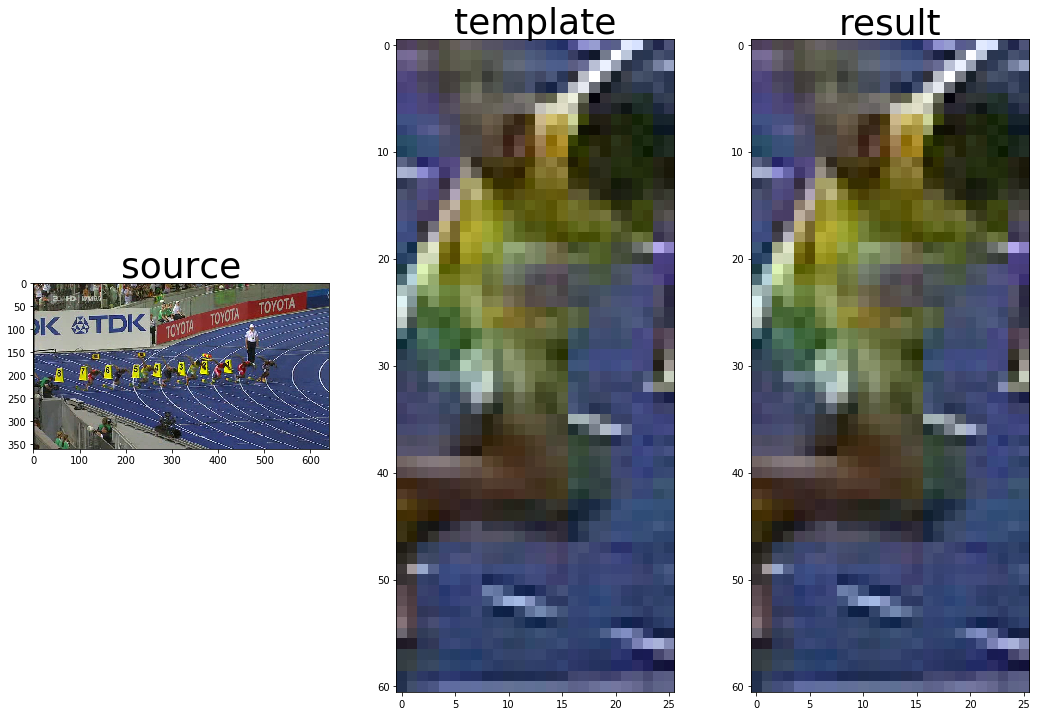

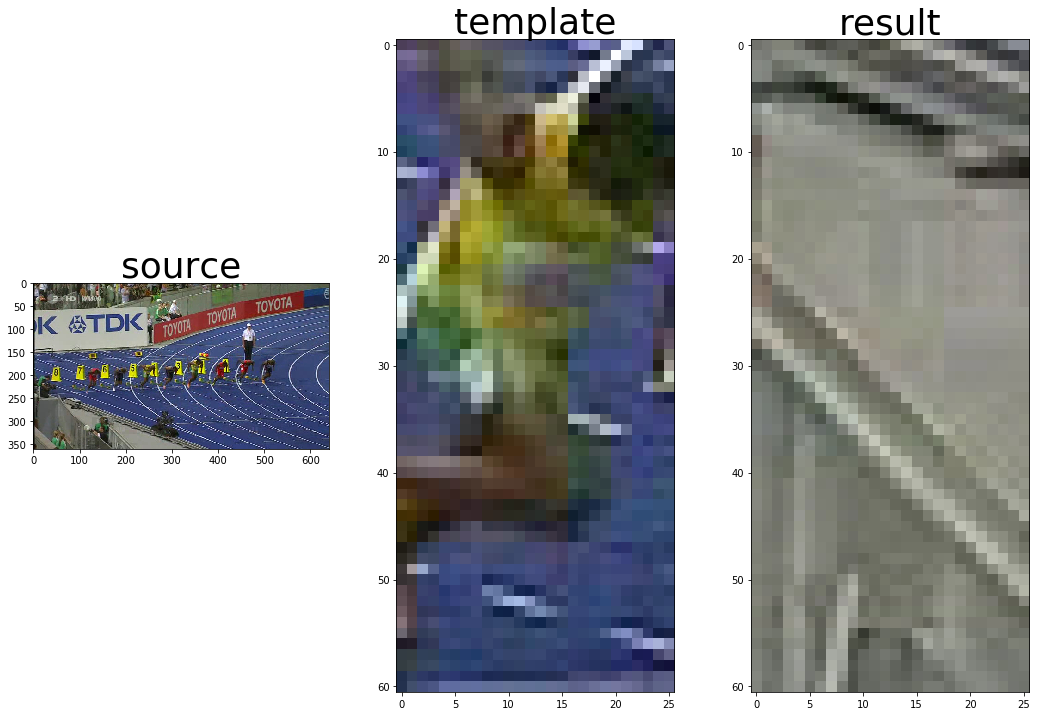

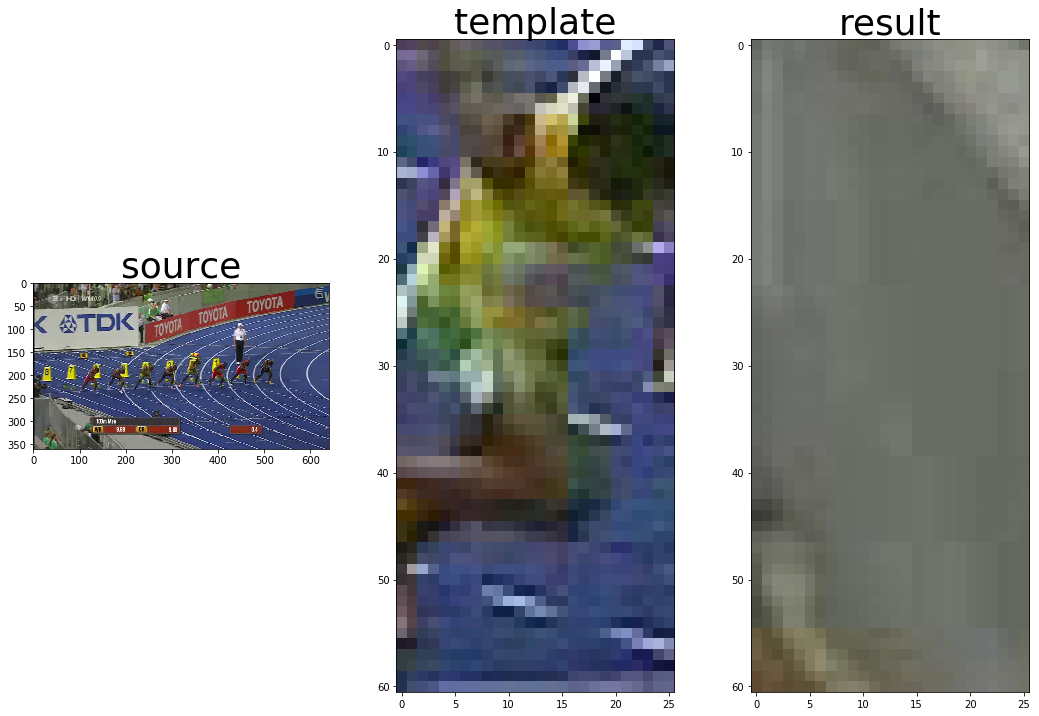

In [350]:
test(bolt, bolt_df, NCC) # step is 3 frames

# SAD method

In [333]:
class SAD:
    @staticmethod
    def run(img, template):
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
        
        imgH, imgW = img.shape[:2]
        winH, winW = template.shape[:2]
        
        score = np.Inf
        coords = (0, 0)
        
        for (x, y, window) in sliding_window(img, stepSize=1, windowSize=(winW, winH)):
            # if the window does not meet our desired window size, ignore it
            if window.shape[0] != winH or window.shape[1] != winW:
                continue
            
            tmp = np.sum(np.abs(window - template))
            if score > tmp:
                score = tmp
                coords = (x, y)
        
        return coords
        
    @staticmethod
    def test(source, template):
        (x, y) = SAD.run(source, template)
        result = cut_img(source, (x, y, template.shape[1], template.shape[0]))
        imgs_show([(source, "source"), (template, "template"), (result, "result")], 1)

## SAD Test

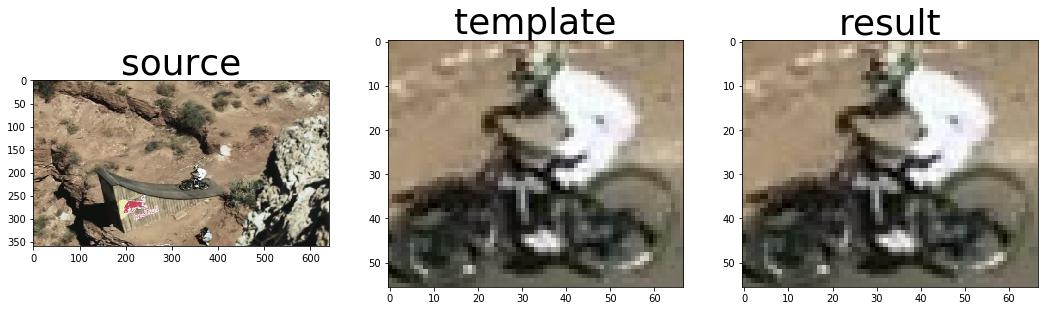

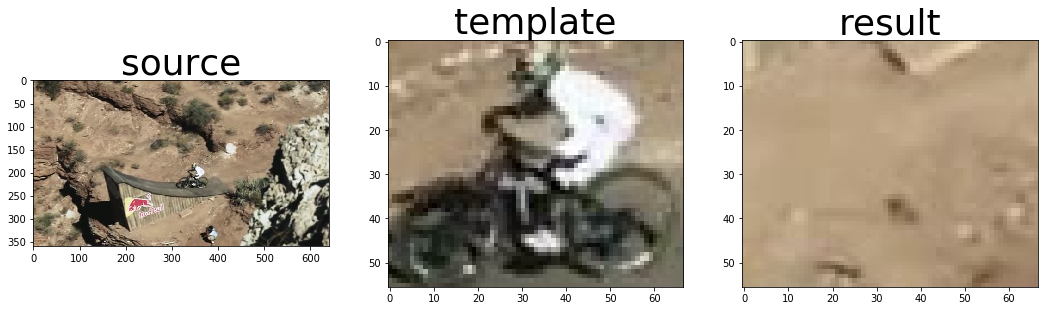

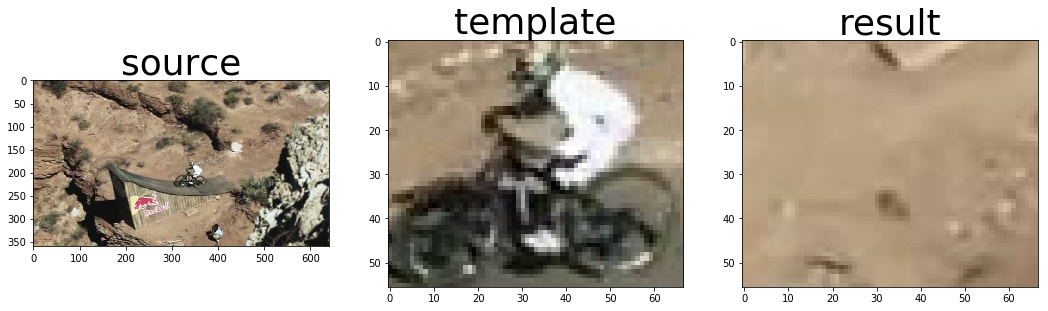

In [341]:
test(bike, bike_df, SAD) # step is 3 frames

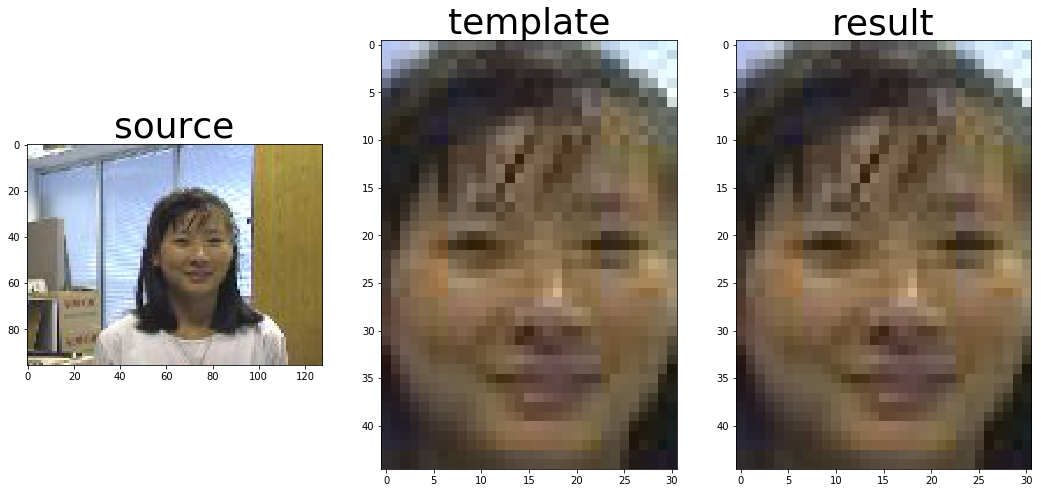

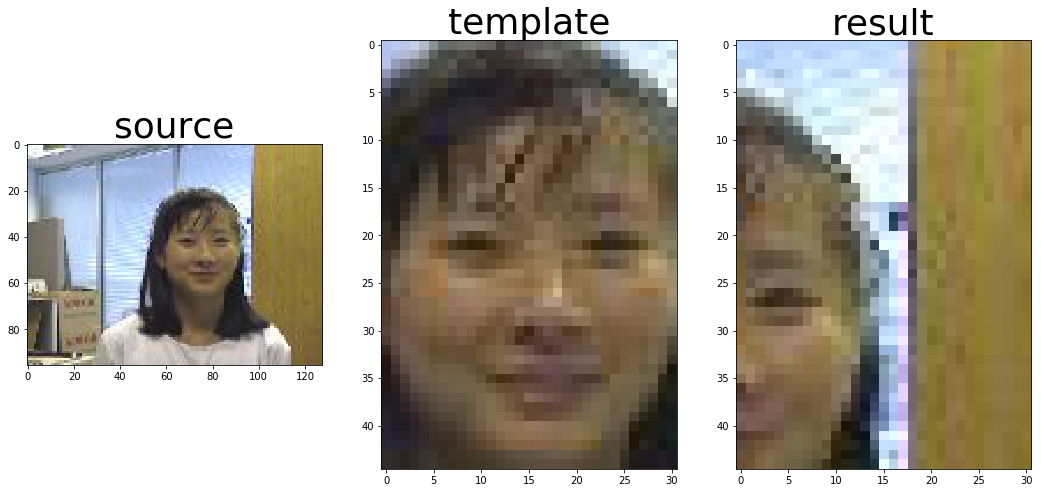

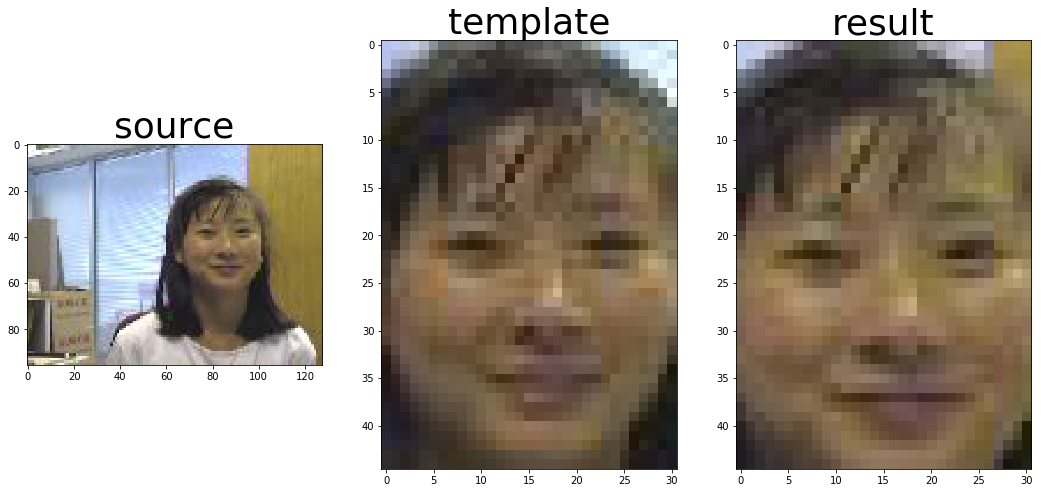

In [342]:
test(girl, girl_df, SAD) # step is 3 frames

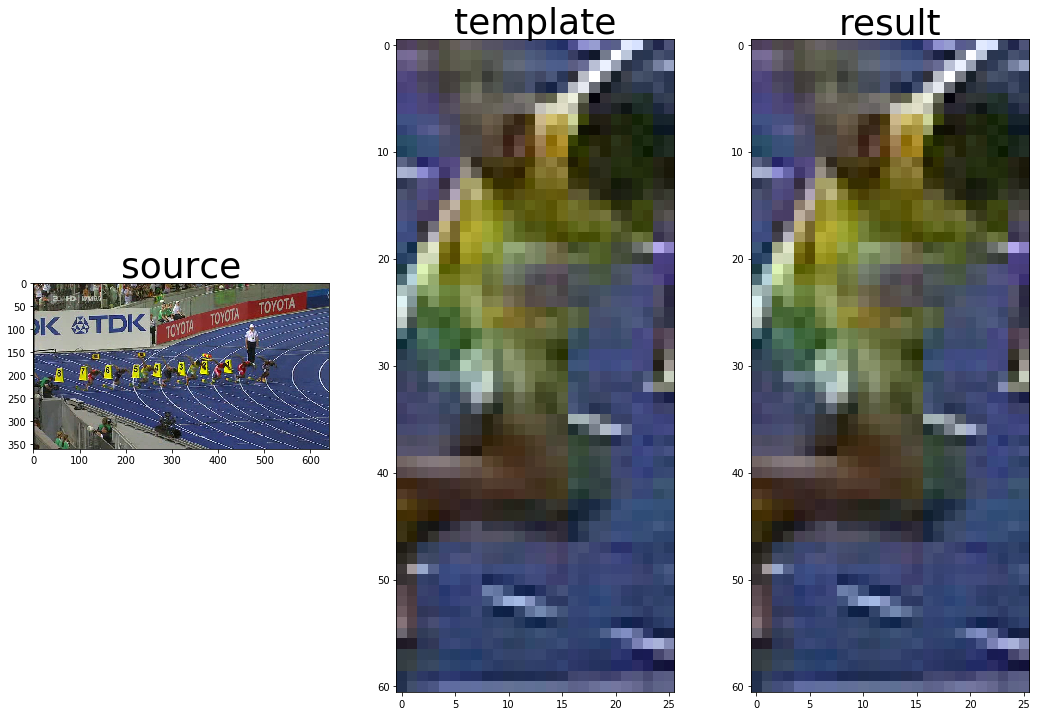

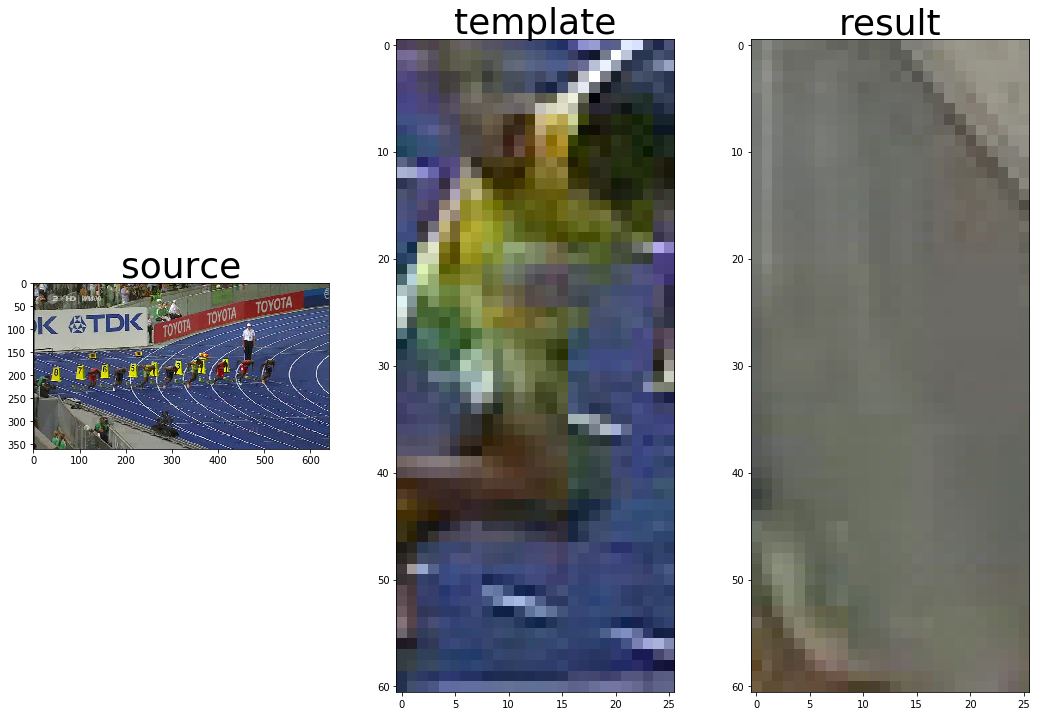

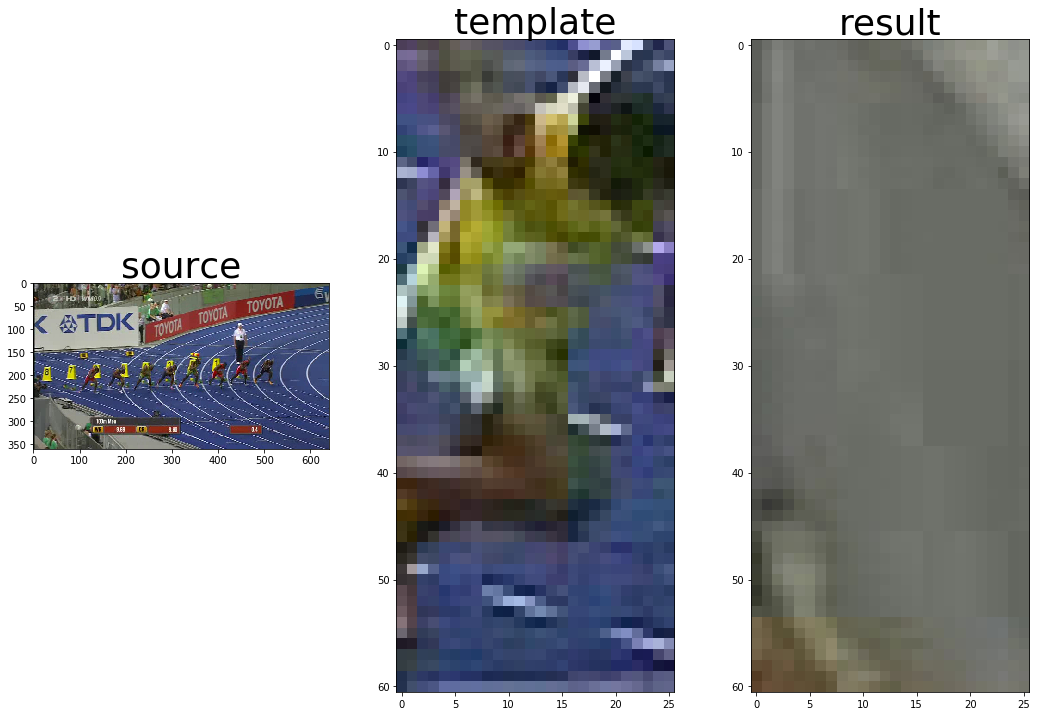

In [343]:
test(bolt, bolt_df, SAD) # step is 3 frames